In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# # filter only test playersex
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

1187

In [25]:
df.head()

,playerId,target1,target2,target3,target4,date,home,positionName,pstatsDate,battingOrder,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaN,NaT,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaN,NaT,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaN,NaT,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaN,NaT,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaN,NaT,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


In [26]:
list(df.columns)

['playerId',
 'target1',
 'target2',
 'target3',
 'target4',
 'date',
 'home',
 'positionName',
 'pstatsDate',
 'battingOrder',
 'groundOuts',
 'runsScored',
 'homeRuns',
 'strikeOuts',
 'baseOnBalls',
 'intentionalWalks',
 'hits',
 'hitByPitch',
 'stolenBases',
 'groundIntoTriplePlay',
 'plateAppearances',
 'totalBases',
 'rbi',
 'catchersInterference',
 'pickoffs',
 'gamesPlayedPitching',
 'gamesStartedPitching',
 'completeGamesPitching',
 'winsPitching',
 'lossesPitching',
 'groundOutsPitching',
 'runsPitching',
 'strikeOutsPitching',
 'atBatsPitching',
 'caughtStealingPitching',
 'inningsPitched',
 'saveOpportunities',
 'battersFaced',
 'outsPitching',
 'balks',
 'pickoffsPitching',
 'gamesFinishedPitching',
 'inheritedRunners',
 'catchersInterferencePitching',
 'sacBuntsPitching',
 'saves',
 'holds',
 'blownSaves',
 'assists',
 'putOuts',
 'chances',
 'SLG',
 'runsScored__date__maxNorm',
 'homeRuns__date__maxNorm',
 'hits__date__maxNorm',
 'SLG__date__maxNorm',
 'rbi__date__maxNor

### cleaning dataset

In [27]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin

class PdVectorDiscretizer(KBinsDiscretizer):
    def __init__(self, n_bins: int, strategy: str = 'quantile'):
        super().__init__(n_bins=n_bins, strategy=strategy, encode='ordinal')
        
    def to_matrix(self, X: pd.Series):
        X = X.dropna().to_numpy()
        X = X[:, None]
        return X
    
    def fit(self, X: pd.Series, y=None):
        X = self.to_matrix(X)
        return super().fit(X, y)

    def transform(self, X: pd.Series):
        notnan = X.notna()
        outputX = np.zeros((len(X), 1)).astype(np.int64)

        if notnan.sum() > 0:
            Xm = self.to_matrix(X)
            discreteX = super().transform(Xm)
            discreteX += 1
            outputX[notnan] = discreteX
        outputX = pd.DataFrame(outputX, columns=[X.name])
        return outputX.astype(np.int16)

class PdDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins: int, strategy: str = 'quantile'):
        self.n_bins=n_bins
        self.strategy=strategy
    
    def fit(self, X: pd.DataFrame, y=None):
        tmfs = {}
        for feature in X:
            tmf = PdVectorDiscretizer(self.n_bins, self.strategy)
            tmfs[feature] = tmf.fit(X.loc[:, feature])
        self.tmfs = tmfs
        return self

    def transform(self, X: pd.DataFrame):
        return pd.concat([tmf.transform(X.loc[:, feature])
                          for feature, tmf in self.tmfs.items()], axis=1)

In [28]:
from itertools import combinations, product
from typing import List, Union

class SingleInteractionComputer:
    def __init__(self, features: List[Union[int, str]],
                 fill_nan: str = 'NaN'):
        self.features = list(features)
        self.fill_nan = fill_nan
        self.interaction_name = 'X'.join(self.features)
        
    def compute_matrices(self, X: pd.DataFrame):
        return X.loc[:, self.features].fillna(self.fill_nan)
    
    def compute_interactions(self, X: pd.DataFrame):
        
        interactions = product(*[series.unique() for _, series in X.items()])

        return pd.DataFrame(list(interactions), columns=self.features)
        
    def fit(self, X: pd.DataFrame):
        X = self.compute_matrices(X)
        table = self.compute_interactions(X)
        table.loc[:, self.interaction_name] = np.arange(0, len(table))
        self.table = table
        
    def transform(self, X: pd.DataFrame):
        outputX = self.compute_matrices(X)
        outputX = outputX.merge(self.table, on=self.features, how='left')
        outputX.drop(self.features, axis=1, inplace=True)
#         outputX.fillna(0, inplace=True)
        assert len(outputX) == len(X)
        assert len(outputX.columns) == 1
        assert outputX.isna().sum().all() == 0, self.features 
        return outputX.astype(np.int16)
        

class InteractionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, iteraction_level: int = 2):
        self.iteraction_level = iteraction_level
        
    def gen_interaction_indexes(self, features: List[Union[int, str]]):
        interactions = []
        for level in range(2, self.iteraction_level+1):
            combination = list(combinations(features, level))
            interactions += combination
        return interactions
    
    def fit(self, X: pd.DataFrame, y = None):
        features = list(X.columns)
        total_interactions = self.gen_interaction_indexes(features)
        self.tmfs = {}
        for interaction in total_interactions:
            tmf = SingleInteractionComputer(interaction)
            tmf.fit(X)
            self.tmfs[tmf.interaction_name] = tmf
        return self
    
    def transform(self, X: pd.DataFrame):
        return pd.concat([tmf.transform(X) 
                          for tmf in self.tmfs.values()], axis=1)

In [29]:
def filter_by_idx(df, idx):
    return df.loc[idx, :].reset_index(drop=True)

In [30]:
## split train set
start_test_date = '2021-04-01'
end_test_date = '2021-08-01'

In [31]:
train_idx = df['date'] <= start_test_date

In [32]:
valid_idx = df['date'].between(start_test_date, end_test_date, inclusive=False)

In [33]:
raw_train_data = filter_by_idx(df, train_idx)

In [34]:
raw_valid_data = filter_by_idx(df, valid_idx)

In [35]:
# drop non game dates

In [36]:
# season_to_keep = ['Reg Season 1st Half', 'All-Star Break',
#        'Reg Season 2nd Half', 'Postseason']

### preprocessing 

In [37]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from pipeline.core import PdFeatureUnion
# from sklearn.compose import ColumnTransformer
# from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
# from pipeline.stats import StatisticGen, LagGen, FeaturesTable
# from pipeline.categories import Categorify
# from pipeline.season import join_season_info
# from pipeline.players import join_players_info
# from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [38]:
target_cols = ['target1', 'target2', 'target3', 'target4']

####  categories 

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
# categories encoding
categories = ['seasonPart', 'year', 'teamId',
              'primaryPositionName', 'status', 'playerId']
interaction_categories = ['primaryPositionName', 'opponentTeamId']

In [41]:
filter_cat_tmf = FunctionTransformer(lambda df: df.loc[:, categories])
filter_int_cat_tmf = FunctionTransformer(lambda df: df.loc[:, interaction_categories])

In [42]:
categories_pipeline = Pipeline([('filter', filter_cat_tmf),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [43]:
interaction_categories_pipeline = Pipeline([('filter', filter_int_cat_tmf)])

#### CONT FEATURES 

In [44]:
from sklearn.preprocessing import KBinsDiscretizer

In [45]:
CONT_FEATS = ['rbi', 'homeRuns',
              'runsScored__date__maxNorm',
 'homeRuns__date__maxNorm',
 'hits__date__maxNorm',
 'SLG__date__maxNorm',
 'rbi__date__maxNorm',
 'runsPitching__date__maxNorm',]
filter_cont_tmf = FunctionTransformer(lambda df: df.loc[:, CONT_FEATS].fillna(-1))
cont_pipeline = Pipeline([('get_cont', filter_cont_tmf),
                          ('disc', PdDiscretizer(n_bins=5, strategy='uniform'))])

### together 

In [46]:
from sklearn.preprocessing import MaxAbsScaler

In [47]:
interaction_feature_tmf = Pipeline([('union', PdFeatureUnion([('conts', cont_pipeline), 
                                                            ('cats', interaction_categories_pipeline)])),
                                    ('int', InteractionEncoder()),
                                    ('oneHot', OneHotEncoder(handle_unknown='ignore'))
                                   ])

In [48]:
join_feature_tmf = FeatureUnion([('int', interaction_feature_tmf), 
                                 ('cats', categories_pipeline),
                                ('conts', cont_pipeline)])

In [49]:
pipeline = Pipeline([('gen_features', join_feature_tmf),
                     ('scale', MaxAbsScaler())])

In [50]:
train_features = pipeline.fit_transform(raw_train_data)

In [51]:
valid_features = pipeline.transform(raw_valid_data)

In [52]:
train_features

<1408969x3096 sparse matrix of type '<class 'numpy.float64'>'
	with 83129171 stored elements in Compressed Sparse Row format>

In [53]:
# checking for nans
for i in range(train_features.shape[1]):
    assert not np.isnan(train_features[:, i].toarray()).any(), i

In [54]:
from sklearn.linear_model import Lasso, LinearRegression

In [55]:
models = []
for target_name in target_cols:
    print(target_name)
    _model = LinearRegression()
    _model.fit(train_features, raw_train_data[target_name])
    models.append(_model)
    

target1
target2
target3
target4


In [56]:
_prediction = np.stack([_model.predict(valid_features)
                       for _model in models], axis=1)

In [75]:
_prediction = np.clip(_prediction, 0, 100)

In [76]:
prediction = pd.DataFrame(_prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

In [77]:
prediction[['playerId', 'date'] + target_cols] = raw_valid_data[['playerId', 'date'] + target_cols]

In [78]:
from evaluate.metrics import compute_metrics

In [79]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(prediction)

{'mae_mean': 2.0680304224413724,
 'mae_1': 1.6761793058502876,
 'mae_2': 2.9293342761650347,
 'mae_3': 1.8364404261252698,
 'mae_4': 1.830167681624898}

In [80]:
(prediction.groupby(prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,2.146494,1.719818,3.065404,1.811165,1.989591
5,2.097034,1.720202,2.962647,1.903104,1.802182
6,2.064027,1.663078,2.901807,1.884151,1.807071
7,1.888357,1.544581,2.685047,1.673800,1.650002


In [92]:
(prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False)).head(20)

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,34.721675,23.374543,38.638976,33.742852,43.130327
594798,19.850094,12.489207,25.540861,18.382908,22.987401
665487,18.711859,16.583367,15.329372,19.595935,23.338764
665489,15.547996,18.792889,18.640710,13.071193,11.687192
545361,15.353798,11.147138,21.745807,11.644139,16.878109
547180,14.860840,10.848331,17.696410,16.442682,14.455937
519317,14.305335,15.249833,15.019228,14.587866,12.364413
405395,14.089667,9.183367,12.701025,11.692958,22.781320
592450,13.610214,16.544638,11.289529,15.606050,11.000641


In [82]:
hardest_id = filter_by_id(prediction, [660271])

In [83]:
(hardest_id.groupby(['playerId', hardest_id.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     61.054648  46.109641  56.030335  61.926094  80.152521
         6     35.020653  17.835791  42.025436  32.979979  47.241408
         5     28.986027  19.777645  38.580653  25.767826  31.817984
         4     25.107025  19.621776  25.003151  26.535851  29.267324

In [84]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [85]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [86]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [87]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

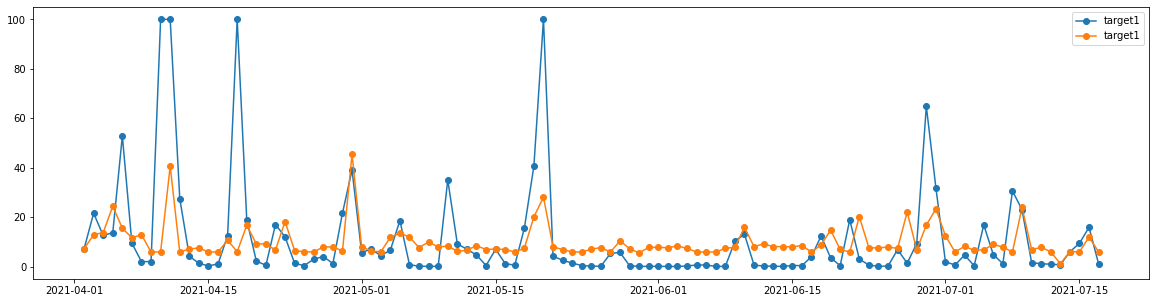

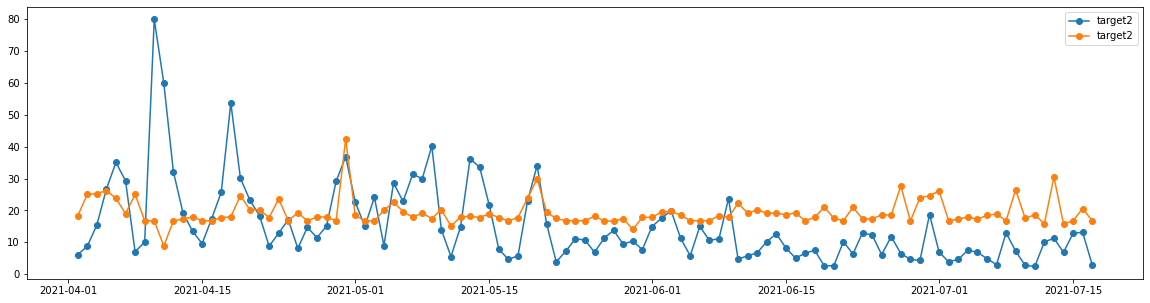

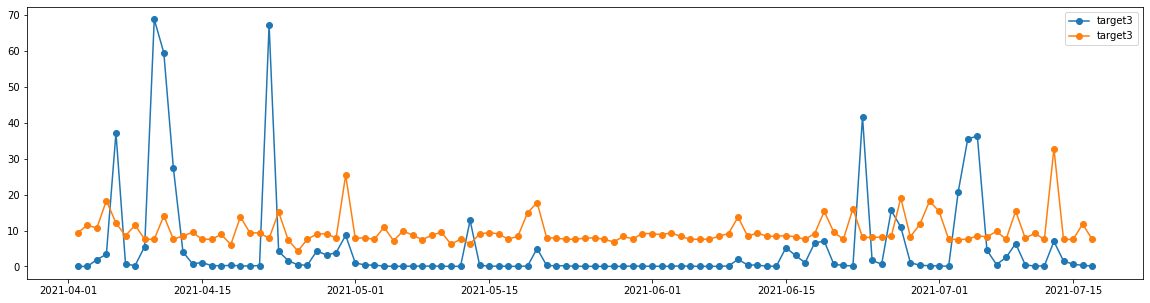

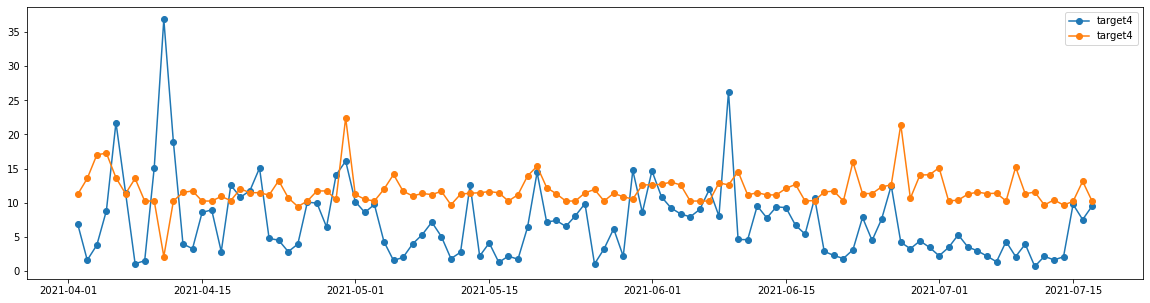

In [95]:
for index in range(1, 5):
    plot_pred(prediction, playerId=502110, index=index)

In [70]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [71]:
fi_data = valid_data

NameError: name 'valid_data' is not defined

In [ ]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [ ]:
all_features_list = list(features.columns)

In [ ]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

In [ ]:
fi_reg

In [ ]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [ ]:
output_path = 'prediction/drop_lstm'
os.makedirs(output_path, exist_ok=True)

In [ ]:
# valid_test_prediction.to_csv(os.path.join(output_path, 'april_to_jul.csv'), index=False)